# Analiza članaka sa istrain.hr portala

**Mario Sliško**

In [2]:
from base64 import encode
from itertools import count
import json, re
from collections import Counter  
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Definiranje ključnih riječi po kojima se uspoređuju članci
Definirane ključne riječi pomoću kojih se uspoređuje tekst iz članaka. Također su još definirani riječnik za formatiranje datuma i stopwords pomoću kojih uklanjamo zaustavne riječi.

In [3]:
keywordsCOV =['covid','korona','sars-cov-2','pandemija','zaražen','samoizolacija','cjepivo','propusnica','cijeplje','lockdown','beroš','respirator']
keywordsCIJEP = ['cijepljen', 'cjepivo','cijepiti', 'astraZeneca','pfizer','moderna','antivakseri']
keywordsA_MASK = ['antimasker']
keywordsA_VAKS = ['antivakser','necijepljen']
stopWordsCro = ["a","ako","ali","baš","bez","bi","bih","bila","bili","bilo","bio","bismo","bit","biti","bolje","bude","čak","čega","čemu","često","četiri","čime","čini","će","ćemo","ćete","ću","da","dakle","dalje","dan","dana","dana","danas","dio","do","dobro","dok","dosta","dva","dvije","eto","evo","ga","gdje","god","godina","godine","gotovo","grada","i","iako","ići","ih","ili","im","ima","imaju","imali","imam","imao","imati","inače","ipak","isto","iz","iza","između","ja","jako","je","jedan","jedna","jednog","jednom","jednostavno","jednu","jer","joj","još","ju","ka","kad","kada","kaj","kako","kao","kaže","kod","koja","koje","kojeg","kojeg","kojem","koji","kojih","kojim","kojima","kojoj","kojom","koju","koliko","kraju","kroz","li","malo","manje","me","među","međutim","mene","meni","mi","milijuna","mislim","mjesto","mnogo","mogao","mogli","mogu","moj","mora","možda","može","možemo","možete","mu","na","način","nad","naime","nakon","nam","naravno","nas","ne","neće","nego","neka","neke","neki","nekog","nekoliko","neku","nema","nešto","netko","ni","nije","nikad","nisam","nisu","ništa","niti","no","njih","o","od","odmah","odnosno","oko","on","ona","onda","oni","onih","ono","opet","osim","ova","ovaj","ovdje","ove","ovim","ovo","ovog","ovom","ovu","pa","pak","par","po","pod","poput","posto","postoji","pred","preko","prema","pri","prije","protiv","prvi","puno","put","radi","reći","s","sa","sad","sada","sam","samo","sati","se","sebe","si","smo","ste","stoga","strane","su","svaki","sve","svi","svih","svoj","svoje","svoju","što","ta","tada","taj","tako","također","tamo","te","tek","teško","ti","tih","tijekom","time","tko","to","tog","toga","toj","toliko","tom","tome","treba","tu","u","uopće","upravo","uvijek","uz","vam","vas","već","vi","više","vrijeme","vrlo","za","zapravo","zar","zato","zbog","zna","znači"]

#Rječnik za formatiranje datuma
monthsDic = {
    ' Siječanj ': '-1-',
    ' Veljača ': '-2-',
    ' Ožujak ': '-3-',
    ' Travanj ': '-4-',
    ' Svibanj ': '-5-',
    ' Lipanj ': '-6-',
    ' Srpanj ': '-7-',
    ' Kolovoz ': '-8-',
    ' Rujan ': '-9-',
    ' Listopad ': '-10-',
    ' Studeni ': '-11-',
    ' Prosinac ': '-12-'
}

## Učitavanje json datoteke i formatiranje datuma
Dodan je naknadno stupac mjesec kako bi olakšao mjesečne prikaze.

In [4]:
df = pd.read_json('scrap_dataClean.json')
df.Date= df.Date.transform(lambda x : list(filter(None,[x.replace(key,value) if key in x else None for key, value in monthsDic.items()]))[0])
df.Date = df.Date.transform(lambda x : datetime.datetime.strptime(x, '%d-%m-%Y'))

df = df[df.Date >= datetime.datetime(2021,1,1,0,0)]
#df = df.sort_values("Date")
#df["Month"] = df.Date.transform(lambda x :datetime.datetime(x.year, x.month, 1,0,0))
df['Month'] = pd.DatetimeIndex(df['Date']).month
df.head()

,ID,Link,Title,Kategorije,Date,Text,Author,Month
0,1,https://www.istrain.hr/index.php/istrain-arhiv...,Porečke Šajete pomogle Drenki: Nabavili drva i...,istrain,2021-12-31,Nakon što smo pisali o gospođi Drenki i uvjeti...,Igor Franković,12
1,2,https://www.istrain.hr/index.php/istrain-arhiv...,Zbog korone u Hrvatskoj umrlo 45 ljudi. Imamo ...,istrain,2021-12-31,U Hrvatskoj je u posljednja 24 sata zabilježen...,IstraIN,12
2,3,https://www.istrain.hr/index.php/istrain-arhiv...,PROVALA U CENTRU ROVINJA Iz ugostiteljskog obj...,istrain,2021-12-31,Rovinjska je policija dovršila kriminalističko...,Igor Franković,12
3,4,https://www.istrain.hr/index.php/istrain-arhiv...,"Svijet čeka 2022. godinu, novogodišnje proslav...",istrain,2021-12-31,"Svijet se priprema za početak 2022., nakon još...",IstraIN,12
4,5,https://www.istrain.hr/index.php/istrain-arhiv...,U e-savjetovanju natječaji vrijedni više od 30...,istrain,2021-12-31,"Ministarstvo poljoprivrede je u četvrtak, 30. ...",IstraIN,12


Izdvajanje članaka koje sadrže ključne riječi

In [5]:
dan=df.groupby("Date").size()

cov_df=df[df['Text'].str.contains('|'.join(keywordsCOV)) | df['Title'].str.contains('|'.join(keywordsCOV))] #df samo za clanke koji su vezani za covid
cij_df=df[df['Text'].str.contains('|'.join(keywordsCIJEP)) | df['Title'].str.contains('|'.join(keywordsCIJEP))] #df samo za clanke koji su vezani za cijepljenje
anM_df=df[df['Text'].str.contains('|'.join(keywordsA_MASK)) | df['Title'].str.contains('|'.join(keywordsA_MASK))] #df samo za clanke koji su vezani za Antimaskere
anV_df=df[df['Text'].str.contains('|'.join(keywordsA_VAKS)) | df['Title'].str.contains('|'.join(keywordsA_VAKS))] #df samo za clanke koji su vezani za Antivaksere 

danCOV=cov_df.groupby("Date").size()
danCIJ=cij_df.groupby("Date").size()
danMAsk=anM_df.groupby("Date").size()
danVAKs=anV_df.groupby("Date").size()


In [6]:
resultT=pd.concat([dan, danCOV,danCIJ,danMAsk,danVAKs],axis=1).fillna(0)
sumaDF = resultT.sum(axis=0,skipna=True,numeric_only=False)
resultT.columns=['Ukupno','Covid','Cijepljenje','Antimaskeri','Antivakseri']

print("Ukupno članaka :" + str(int(sumaDF[0])))
print("Ukupno članaka vezanih za covid:" + str(int(sumaDF[1])))
print("Ukupno članaka vezanih za cijepljenje:" + str(int(sumaDF[2])))
print("Ukupno članaka vezanih za antimaksere:" + str(int(sumaDF[3])))
print("Ukupno članaka vezanih za antivaksere:" + str(int(sumaDF[4])))


Ukupno članaka :9684
Ukupno članaka vezanih za covid:2179
Ukupno članaka vezanih za cijepljenje:968
Ukupno članaka vezanih za antimaksere:0
Ukupno članaka vezanih za antivaksere:50


Prikaz ukupno članaka u usporedbi sa člancima vezanim za covid, cijepljenje, antimaskere i antivaksere (neću koristiti antimaskere u daljnim prikazima)

In [7]:
resultT

,Ukupno,Covid,Cijepljenje,Antimaskeri,Antivakseri
Date,,,,,
2021-01-01,7,0.0,0.0,0.0,0.0
2021-01-02,15,3.0,0.0,0.0,0.0
2021-01-03,15,4.0,1.0,0.0,0.0
2021-01-04,24,7.0,4.0,0.0,0.0
2021-01-05,27,6.0,4.0,0.0,0.0
...,...,...,...,...,...
2021-12-27,31,6.0,3.0,0.0,1.0
2021-12-28,25,5.0,2.0,0.0,1.0
2021-12-29,22,8.0,5.0,0.0,1.0


Na prvom grafu vidimo broj objava po danima za ukupan broj članaka te za oni koji su vezani za covid, cijepljenje, antimaskere te antivaksere. Za članke o covidu vidimo da je malo manji broj objava pri kraju godine (jasnije se vidi u mjesečnom prikazu). Također je zanimljivo primjetiti da se pred kraj godine tek počinju objavljivati članci vezani za antivaksere.

Text(0, 0.5, 'Broj članaka')

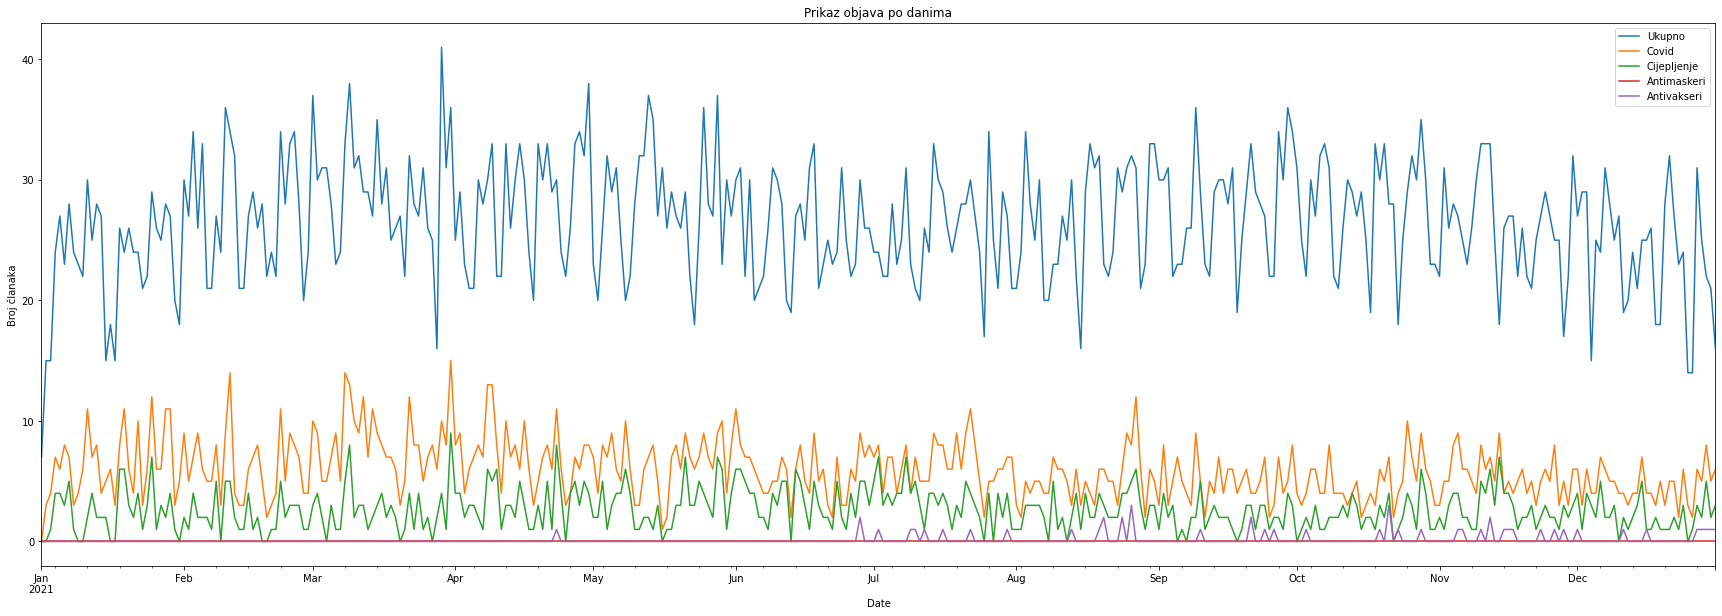

In [8]:
resultT.plot(title="Prikaz objava po danima",figsize=(30,10)).set_ylabel("Broj članaka")

Mjesečni prikaz ukupnog broja članaka u usporedbi sa člancima vezanim za covid, cijepljenje i antivaksere

In [9]:
mjes=df.groupby("Month").size()

#cov_mj=df[df['Text'].str.contains('|'.join(keywordsCOV))|df['Title'].str.contains('|'.join(keywordsCOV))]
mjCOV=cov_df.groupby("Month").size()

#cij_mj=df[df['Text'].str.contains('|'.join(keywordsCIJEP)) | df['Title'].str.contains('|'.join(keywordsCIJEP))]
mjCIJ=cij_df.groupby("Month").size()

#anV_mj=df[df['Text'].str.contains('|'.join(keywordsA_VAKS)) | df['Title'].str.contains('|'.join(keywordsA_VAKS))]
mjVAKs=anV_df.groupby("Month").size()


mjTab=pd.concat([mjes, mjCOV,mjCIJ,mjVAKs],axis=1).fillna(0)
mjTab.columns=['Ukupno','Covid','Cijepljenje','Antivakseri']
#print('Mjesečni prikaz ukupnog broja članaka u usporedbi sa člancima vezanim za covid, cijepljenje i antivaksere')
mjTab

,Ukupno,Covid,Cijepljenje,Antivakseri
Month,,,,
1,706,194,73,0.0
2,766,173,60,0.0
3,910,258,81,0.0
4,844,216,98,1.0
5,861,200,94,0.0
6,773,173,102,2.0
7,792,200,103,7.0
8,826,159,81,9.0
9,837,150,60,5.0


Na ovom prikazu se još bolje primjeti kako se članci vezani za antivaksere tek počinju u u šestom mjesecu, i postepeno rastu prema kraju godine. Po tome možemo zaključiti kako se taj pojam puno više koristi u zadnje vrijeme te kako se ljudi sve više protive cjepivu. 

Text(0, 0.5, 'Broj članaka')

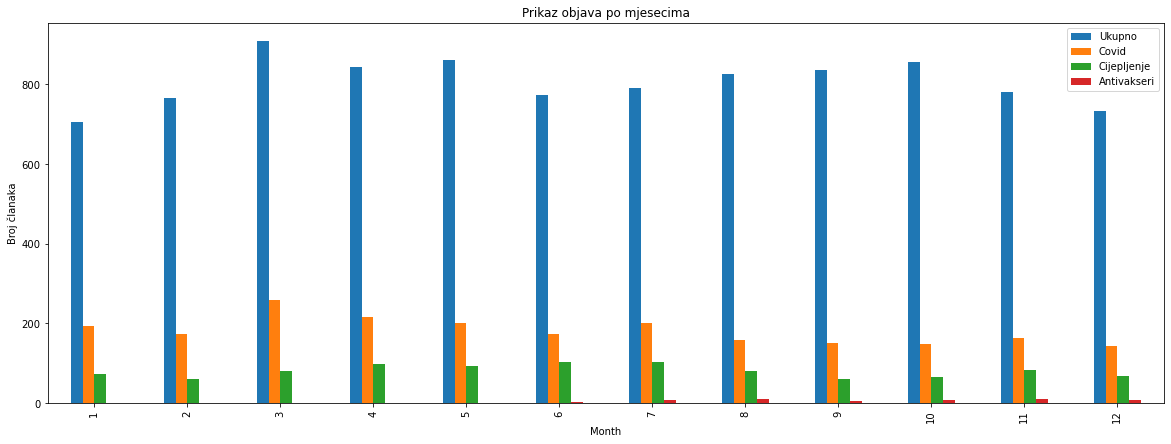

In [10]:
mjTab.plot.bar(title="Prikaz objava po mjesecima",figsize=(20,7)).set_ylabel("Broj članaka")

Prikaz po kategorijama

In [11]:
kat=df.groupby("Kategorije").size().sort_values()
kat_cov=cov_df.groupby("Kategorije").size().sort_values()
kat_cij=cij_df.groupby("Kategorije").size().sort_values()
kat_vak=anV_df.groupby("Kategorije").size().sort_values()

In [12]:
katTab=pd.concat([kat, kat_cov,kat_cij,kat_vak],axis=1).fillna(0)
katTab.columns=['Ukupno','Covid','Cijepljenje','Antivakseri']
print('Prikaz ukupno članaka u usporedbi sa člancima vezanim za covid i cijepljenje')
katTab

Prikaz ukupno članaka u usporedbi sa člancima vezanim za covid i cijepljenje


,Ukupno,Covid,Cijepljenje,Antivakseri
Kategorije,,,,
sport,692,36,7,0.0
kultura,812,48,3,0.0
gospodarstvo,1120,186,58,1.0
crna-kronika,1136,7,2,0.0
politika,1476,233,121,8.0
istrain,4448,1669,777,41.0


Zanimljivo je za primjetiti kako se teme vezane za covid spominju u člancima koji su vezani za sport, kulturu i gospodarstvo. Možemo zaključiti npr. za sport da covid sve više postaje problem za mnoge sportske timove te navijače i sve ostale povezane za sport. 

Text(0.5, 0, 'Broj članaka')

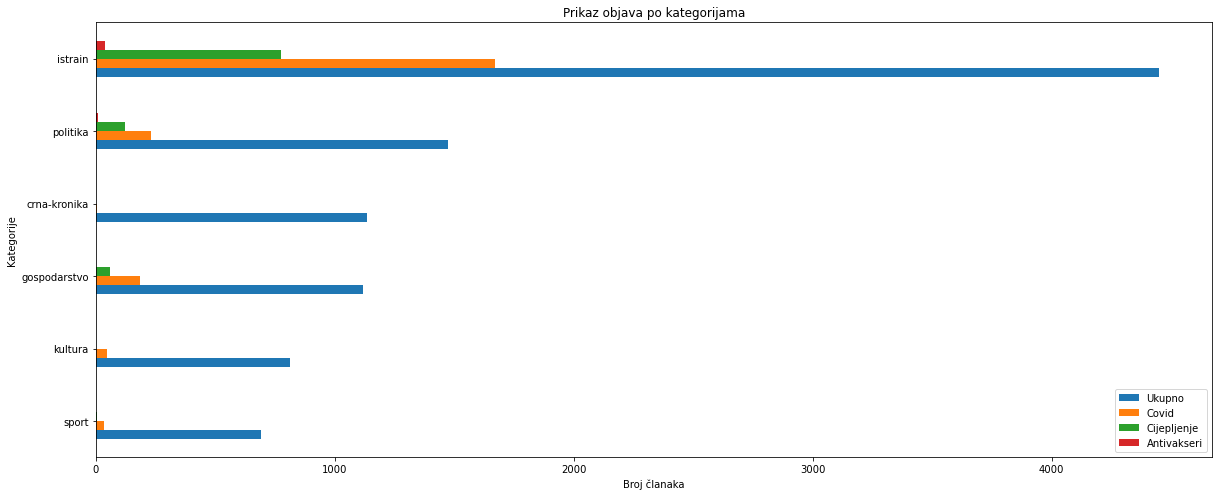

In [13]:
katTab.plot.barh(title="Prikaz objava po kategorijama",figsize=(20,8)).set_xlabel("Broj članaka")

## Čišćenje texsta
Iz teksta je bilo potrebno izbaciti sve znakove koji bi smetali prilikom prikupljanja riječi s največom frekvencijom pojavljlivanja. Također su uklonjene zaustave riječi kako bi ostali sa skupom u kojem se pretežito nalaze imenice.

In [14]:
printtest=cov_df[['Text','Month']]

testVar=printtest['Text'].str.replace('.',"",regex=True)
testVar1 = testVar.str.replace('|(|)|/|\|*|%|$|&|-|_|:|;|1|2|3|4|5|6|7|8|9|0|,',"",regex=True).str.lower()
clTeks =testVar1.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopWordsCro)])) #Uklanjanje stopwords-a

wordTable=pd.concat([printtest['Month'], clTeks],axis=1).fillna(0)
wordTable.columns=['Mjesec','Text']


In [15]:
poljeMj=[]
monthWordTable = wordTable.groupby('Mjesec').sum()#.reset_index(name='Mjesec')

In [16]:
najRijeci=Counter(" ".join(clTeks).split()).most_common(25)
najRijDF = pd.DataFrame(najRijeci,columns=['Rijec','Broj pojavljivanja'])


In [17]:
najMjesec=[]
for i in range(0,12):
    najRijeci1=Counter(" ".join(monthWordTable.iloc[i]).split()).most_common(25)
    najRijeci1
    najRijDF1 = pd.DataFrame(najRijeci1,columns=['Rijec','Broj pojavljivanja'])
    najMjesec.append(najRijDF1)

In [18]:
def WrdCloud(graf):
    wordcloud = WordCloud().generate(' '.join(graf))
    # Generate plot
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


Prikaz TOP 25 rijeci za cijelu godinu

          Rijec  Broj pojavljivanja
0         osoba                3456
1         covid                1545
2         osobe                1441
3          sata                1270
4     hrvatskoj                1247
5      županije                1016
6          broj                1002
7        ukupno                 978
8      istarske                 910
9   cijepljenje                 910
10      cjepiva                 897
11    slučajeva                 815
12         pula                 805
13    liječenju                 755
14        mjera                 742
15       zaraze                 699
16   pacijenata                 687
17        javno                 681
18    zdravstvo                 665
19     protekla                 663
20   cijepljeno                 656
21     trenutno                 610
22      bolnici                 607
23      stožera                 566
24   posljednja                 553


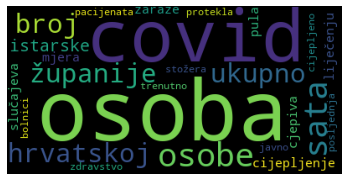

In [19]:
print(najRijDF)
WrdCloud(najRijDF['Rijec'])

Prikaz TOP 25 rijeci za po mjesecima

In [20]:
#najMjesec  #kada se makne komentar, ispise se 12 tablica za svaki mjesec

Ponovno možemo vidjeti da se pr kraju godine sve više spominje cijepljenje kao što sam prije naveo. U prikazu vidimo top 25 riječi za 1., 2., 11., i 12. mjesec. Riječi kao što su "cijepljenje", "cijepivo" i slične se za prva 2  mjeseca uopće ne nalaze u top 25 riječi a za zadnja 2 mjeseca se te iste riječi nalaze na visokom mjestu pojavljivanja.

1. mjesec
            Rijec  Broj pojavljivanja
0           osoba                 313
1           covid                 133
2           osobe                 126
3        županije                 118
4           mjera                 113
5       hrvatskoj                 111
6         cjepiva                 106
7            sata                  94
8            broj                  93
9        istarske                  92
10           pula                  90
11        stožera                  75
12       trenutno                  72
13         ukupno                  71
14      slučajeva                  69
15          rekao                  69
16          mjere                  66
17       aktivnih                  65
18          javno                  64
19          istri                  64
20      liječenju                  63
21          ljudi                  61
22      zdravstvo                  60
23    cijepljenje                  60
24  samoizolacije                  57


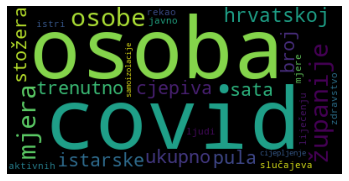

In [21]:
print("1. mjesec")
print(najMjesec[0])
WrdCloud(najMjesec[0]['Rijec'])

2. mjesec
         Rijec  Broj pojavljivanja
0        osoba                 233
1        osobe                 133
2        covid                 102
3        mjera                 100
4    hrvatskoj                  99
5     županije                  92
6         sata                  85
7       ukupno                  85
8     istarske                  82
9      cjepiva                  80
10    trenutno                  75
11        pula                  67
12     stožera                  66
13       rekao                  65
14      zaraze                  64
15   slučajeva                  61
16       istri                  59
17        broj                  57
18    aktivnih                  57
19   liječenju                  56
20     veljače                  56
21        kuna                  52
22       javno                  51
23  pacijenata                  50
24     zaštite                  49


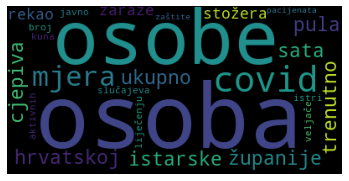

In [22]:
print("2. mjesec")
print(najMjesec[1]) #mogu se ispisati za sve mjesece, samo se promijeni 
WrdCloud(najMjesec[1]['Rijec'])

11. mjesec
          Rijec  Broj pojavljivanja
0         osoba                 314
1         covid                 158
2        ukupno                 111
3         osobe                 109
4          sata                 108
5   cijepljenje                  92
6          broj                  91
7        zaraze                  82
8     hrvatskoj                  82
9     slučajeva                  81
10      bolnici                  80
11     županije                  78
12   pacijenata                  75
13   cijepljeno                  72
14     istarske                  70
15         pula                  70
16    liječenju                  62
17        općoj                  57
18        javno                  54
19      cjepiva                  54
20       nalazi                  54
21    zdravstvo                  53
22      zaštite                  48
23        novih                  47
24   posljednja                  47


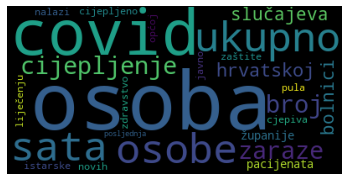

In [24]:
print("11. mjesec")
print(najMjesec[10]) #mogu se ispisati za sve mjesece, samo se promijeni 
WrdCloud(najMjesec[10]['Rijec'])

12. mjesec
           Rijec  Broj pojavljivanja
0          osoba                 326
1         ukupno                 145
2          covid                 130
3           sata                 125
4          osobe                 120
5           broj                  97
6      hrvatskoj                  92
7     cijepljeno                  92
8     pacijenata                  91
9           pula                  85
10        zaraze                  84
11     slučajeva                  74
12     liječenju                  70
13       bolnici                  69
14    posljednja                  64
15         općoj                  62
16      županije                  61
17   cijepljenje                  61
18         javno                  59
19       cjepiva                  58
20     zdravstvo                  57
21      istarske                  56
22  stanovništva                  53
23          kuna                  53
24        odjelu                  51


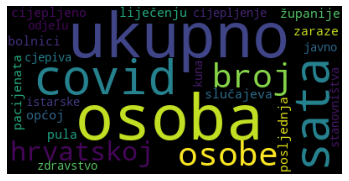

In [25]:
print("12. mjesec")
print(najMjesec[11]) #mogu se ispisati za sve mjesece, samo se promijeni 
WrdCloud(najMjesec[11]['Rijec'])